In [3]:
#! python
#from pyFWI import *
from FWIFunctions import *
import sys, re, datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

import xarray as xr

path = '/Users/xjliu/Desktop/My_research/Climate_Risk/climate-risk-map-hazards/FireWeatherIndex/'

## The requirements of the FWI calculation stipulate that 
### 2 m temperature (∘C), 10 m wind speed (km h−1), and 2 m relative humidity (%) measurements be taken at noon LST for each global time zone and that precipitation (mm) be accumulated over the previous 24 h ending at noon LST of each day 

#### Loadthe FWI data calculated by ECMWF. 
Data is downloaded from https://zenodo.org/records/3539654

In [33]:
import xarray as xr
# Load the NetCDF file
file_path = "~/Downloads/fire_weather_index_2018.nc"  # Replace with your NetCDF file path
ds = xr.open_dataset(file_path)
## convert longitude from 0-360 to -180-180. 
fwi = ds.FWI
fwi['Longitude'] = fwi['Longitude'].where(fwi['Longitude'] < 180, fwi['Longitude']-360)
## reorder the data array based on longitude
fwi = fwi.sortby('Longitude')
fwi = fwi.isel(Time=slice(212,217)) # Aug 1 to Aug 6

ds = xr.open_dataset('~/Downloads/fine_fuel_moisture_code_2018.nc')
## convert longitude from 0-360 to -180-180. 
fmc = ds.FFMC
fmc['Longitude'] = fmc['Longitude'].where(fmc['Longitude'] < 180, fmc['Longitude']-360)
## reorder the data array based on longitude
fmc = fmc.sortby('Longitude')
fmc = fmc.isel(Time=slice(212,217)) # Aug 1 to Aug 6

In [36]:
ds = xr.open_dataset('~/Downloads/duff_moisture_code_2018.nc')
dmc = ds.DMC
dmc['Longitude'] = dmc['Longitude'].where(dmc['Longitude'] < 180, dmc['Longitude']-360)
## reorder the data array based on longitude
dmc = dmc.sortby('Longitude')
dmc = dmc.isel(Time=slice(212,217)) # Aug 1 to Aug 6

In [37]:
ds = xr.open_dataset('~/Downloads/drought_code_2018.nc')
dc = ds.DC
dc['Longitude'] = dc['Longitude'].where(dc['Longitude'] < 180, dc['Longitude']-360)
## reorder the data array based on longitude
dc = dc.sortby('Longitude')
dc = dc.isel(Time=slice(212,217)) # Aug 1 to Aug 6

#### Overlay the state map

(45.0, 50.0)

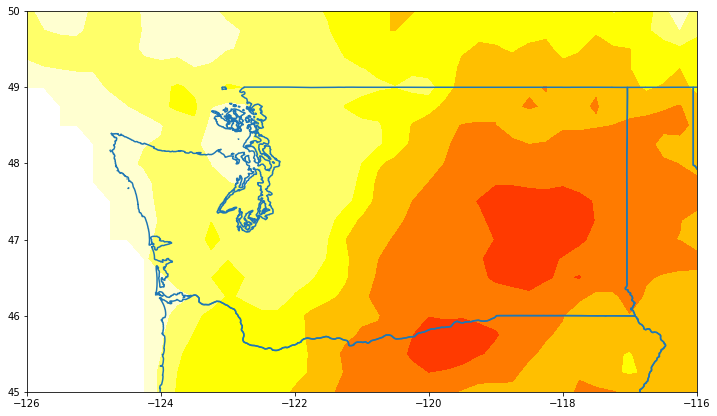

In [6]:
states = gpd.read_file('/Users/xjliu/Desktop/My_research/Climate_Risk/cb_2018_us_state_500k/cb_2018_us_state_500k.shp')
#states.boundary.plot()

fig, ax = plt.subplots(figsize=(12, 8))
contours=ax.contourf(fwi_sorted.Longitude, fwi_sorted.Latitude, fwi_sorted[210:240,:,:].mean('Time'),
                     levels=np.linspace(0,100,11),
                    cmap='hot_r')
#plt.colorbar(contours,extend='both')
states.boundary.plot(ax=ax)
ax.set_xlim([-126,-116])
ax.set_ylim([45,50])

### Load ERA5 data needed for FWI
- Note that precip of ERA5 is in a strange setup. It is in the format of (time, step) where time is the forecast/reference time and step is hours starting from the reference time. For example, if I want to download preciptation of UTC 0 to UTC 24 of Aug 1, what ERA5 provided is actually data in a format of (time, step), Where time is a length=3 forecast reference time -- UTC 18 of July 31, UTC 6 of Aug 1 and UTC 18 of Aug 1. Step is the hour into forecast. It doesn't have data for the first 5 steps and the last seven steps. 
- The preciptation variable needed is the 24-hour accumulated precipitation until local noon, which is UTC 20:00 for Washington. In order to get the previous 24-hour accumulated precipitation until local noon (UTC = 20:00 for Washington state) , I would need the 12-step at time==UTC 18 and then the 12-step at time==UTC6. 
- To get this variable, what I did is collapsing the time and step dimensions into one dimension. Then I average the 21 UTC of previous day to 20UTC of current day and make it the precipitation value of the current day. For example, to get FWI of Aug 1, I need T, q, and uv of Aug 1, and precip accumualted from 21UTC of July 31 to 20UTC of Aug 1. 
- relative humidity at 2m is not available for downloading. It can be calculated using T2m and Tdew at 2m. 
- Equations from https://essd.copernicus.org/articles/12/1823/2020/
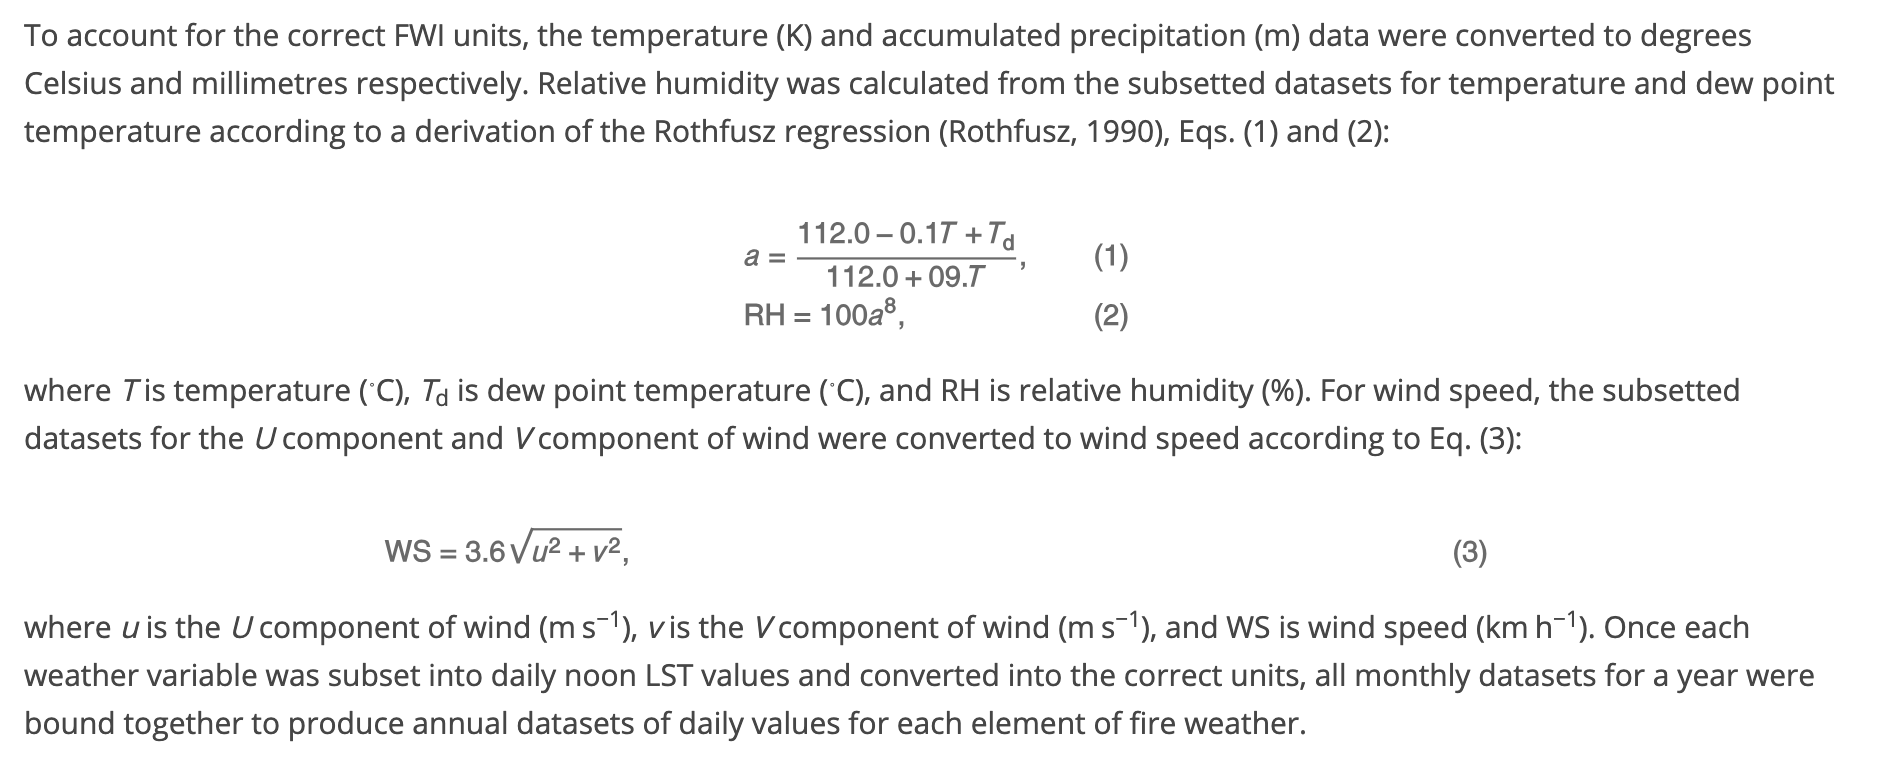 

#### Calculate 24-hour accumulated precipitation

In [8]:
path = '/Users/xjliu/Desktop/My_research/Climate_Risk/climate-risk-map-hazards/FireWeatherIndex/'
ds_prec = xr.open_dataset(path+'precip.grib', engine='cfgrib') ## prec is 
#plt.contourf(var2.longitude,var2.latitude,var2.tp[0,5,:,:])
ds_prec_stacked = ds_prec.stack(timestep = ("time","step"))
ds_prec_stacked = ds_prec_stacked.transpose("timestep","latitude", "longitude")
ds_prec_stacked=ds_prec_stacked.sortby('timestep')
# select the time samples that starts from local noon to local noon of the next day, for July 31 to August 6. 
ds_prec_sel = ds_prec_stacked.sel(timestep=slice(('2018-07-31 18:00:00','0 days 03:00:00'),('2018-08-06 18:00:00','0 days 02:00:00')))

## Take the 24-hour accumulated precipitation and assign the time stamp
prec_daily = xr.concat([ds_prec_sel.tp[i*24:(i+1)*24,:,:].sum('timestep')  for i in range(6)],dim='timestep')
date_range = pd.date_range(start='2018-08-01', end='2018-08-06', freq='D')
prec_daily = prec_daily.assign_coords(timestep=("timestep", date_range))
prec_daily.timestep

<xarray.DataArray 'timestep' (timestep: 6)>
array(['2018-08-01T00:00:00.000000000', '2018-08-02T00:00:00.000000000',
       '2018-08-03T00:00:00.000000000', '2018-08-04T00:00:00.000000000',
       '2018-08-05T00:00:00.000000000', '2018-08-06T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    number    int64 0
    surface   float64 0.0
  * timestep  (timestep) datetime64[ns] 2018-08-01 2018-08-02 ... 2018-08-06

#### Calculate Relative humidity at 2m

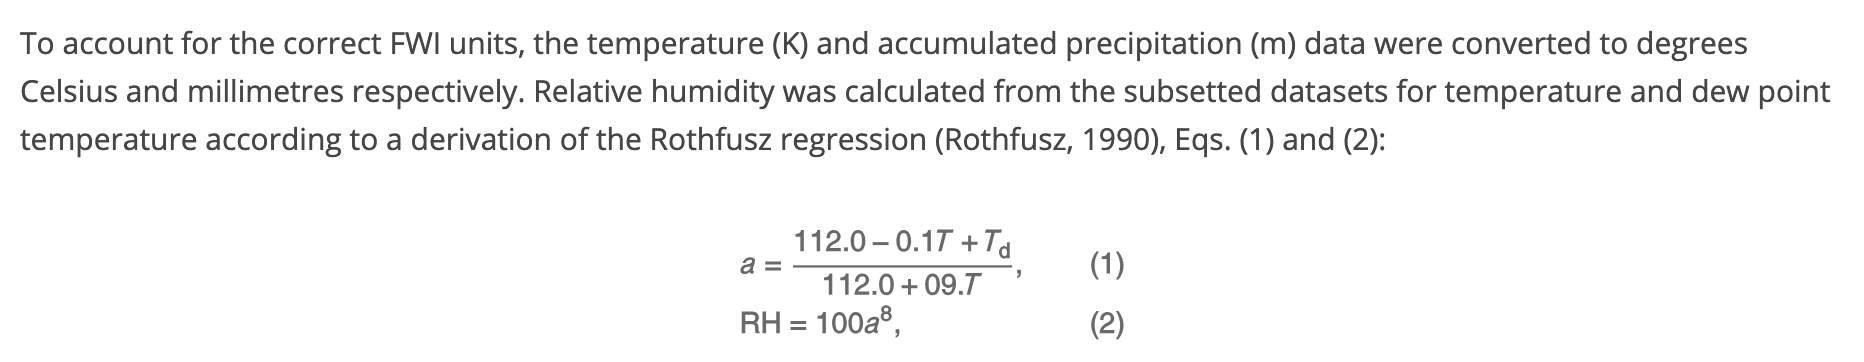

In [23]:
ds_uvT = xr.open_dataset(path+'surface_var.grib', engine='cfgrib')
a = (112.0 - 0.1*ds_uvT.t2m + ds_uvT.d2m)/(112.0+9.0*ds_uvT.t2m)
rh = 100*a**8
wind = 3.6*np.sqrt(ds_uvT.u10**2+ds_uvT.v10**2)

In [207]:
# Load the CSV file into a DataFrame
data = pd.read_csv('testBatch.csv') # data format: 1st line -- date format, latitude, ffmc, dmc, and dc values
                                    ## 2nd line --- temperature, relative humidity, wind speed, and rain

## initialize the relevant fire variables, i.e., ffmc, dmc, dc. 
## Calculation of ISI, BUI, FWI does not need value of previous time step and therefore doesn't need to be initialized. 
N = data.shape[0]
ffmc = np.zeros(N+1)
dmc = np.zeros(N+1)
dc = np.zeros(N+1)
isi = np.zeros(N+1)
bui = np.zeros(N+1)
fwi = np.zeros(N+1)
    
ini_val = data.columns.tolist()
lat = float(ini_val[-4])
ffmc[0] = float(ini_val[-3]) # read in the initial value from the title of the data
dmc[0] = float(ini_val[-2])
dc[0] = float(ini_val[-1])

# Rename columns. Note that the initial value of ffmc, dmc, dc and fwi will now be replaced with 'ffmc','dmc','dc','fwi'
df = data.reset_index()
df.columns = ['Date', 'Temp', 'RH', 'Wind', 'Rain', 'Data','format','ffmc','dmc','dc','fwi']
df = df.drop(columns=['ffmc','dmc','dc','fwi'], axis=1)  ## to remove confusion, drop these columns. 


for ii in range(1,N+1):
    ffmc[ii] = FFMC(df['Temp'][ii-1],df['RH'][ii-1],df['Wind'][ii-1],df['Rain'][ii-1],ffmc[ii-1])#TEMP,RH,WIND,RAIN,FFMCPrev)
    dmc[ii] = DMC(df['Temp'][ii-1],df['RH'][ii-1],df['Rain'][ii-1],dmc[ii-1],lat,int(df.Date[ii-1][:2]))#TEMP,RH,RAIN,DMCPrev,LAT,MONTH)
    dc[ii] = DC(df['Temp'][ii-1],df['Rain'][ii-1],dc[ii-1],lat,int(df.Date[ii-1][:2]))#TEMP,RAIN,DCPrev,LAT,MONTH)
    isi[ii] = ISI(df['Wind'][ii-1],ffmc[ii])
    bui[ii] = BUI(dmc[ii],dc[ii])
    fwi[ii] = FWI(isi[ii],bui[ii])
    #print(ii,isi[ii],bui[ii],fwi[ii])

In [46]:
ilat=0
ilon=0
t2m = ds_uvT.t2m[:,ilat,ilon]
rh2m = rh[:,ilat,ilon]
wind2m = wind[:,ilat,ilon]
prec2m = prec_daily[:,ilat,ilon]

N = 6
ffmc = np.zeros(N+1)
dmc = np.zeros(N+1)
dc = np.zeros(N+1)
isi = np.zeros(N+1)
bui = np.zeros(N+1)
fwi = np.zeros(N+1)

In [47]:
for ii in range(1,6):
    ffmc[ii] = FFMC(t2m[ii],rh2m[ii],wind2m[ii],prec2m[ii],fmc[ii-1,ilat,ilon])

In [44]:
fmc

<xarray.DataArray 'FFMC' (Time: 5, Latitude: 721, Longitude: 1440)>
[5191200 values with dtype=float32]
Coordinates:
  * Longitude  (Longitude) float64 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * Latitude   (Latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * Time       (Time) float64 213.0 214.0 215.0 216.0 217.0
Attributes:
    long_name:     Fine Fuel Moisture Code
    grid_mapping:  crs
    proj4:         +proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0
    min:           [4.73404497e-01 1.00090727e-01 1.10531248e-04 1.05020197e-...
    max:           [ 99.83557892  99.64768982  99.46165466  99.69895172  99.7...